In [1]:
# for folders one level below the heirarchy
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)
###########################################


from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.general import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

import cv2
import numpy as np
import ctypes
from ctypes import *
from scipy import misc
from time import sleep
import csv
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480


cupy not installed. Using numpy.


In [2]:
## Step 2: Trail run to troubleshoot camera linking, finding zeroth order point location, and making sure stuff runs. 
# The biggest challenge here is probably finding the 0th order and making sure the location is stable.
# If we are working in an unstable environment, might be worth using cv2 to find the location of 0th order spot.
# However, there are print lines scattered throughout the code to help pinpoint where things go FUBAR.


awareness = ctypes.c_int()
errorCode = ctypes.windll.shcore.GetProcessDpiAwareness(0, ctypes.byref(awareness))
print(awareness.value)
errorCode = ctypes.windll.shcore.SetProcessDpiAwareness(2)
success = ctypes.windll.user32.SetProcessDPIAware()
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\Blink_C_wrapper")
slm_lib = CDLL("Blink_C_wrapper")
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\ImageGen")
image_lib = CDLL("ImageGen")
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])
cam.start_live_video(framerate = "10Hz")
print("Camera Loaded")
RGB = c_uint(1)
is_eight_bit_image = c_uint(0)
slm_lib.Create_SDK(c_uint(1)) # Initialize SDK, c_unit(1) means true
print("Created SDK")
height = c_uint(slm_lib.Get_Height())
width = c_uint(slm_lib.Get_Width())
depth = c_uint(slm_lib.Get_Depth())
center_x = c_uint(width.value//2)
center_y = c_uint(height.value//2)

success = 0
success = slm_lib.Load_lut("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\LUT Files\\19x12_8bit_linearVoltage.lut")
print("Load LUT success")

Image = np.empty([width.value*height.value*3], np.uint8, 'C')
WFC = np.zeros([width.value*height.value*3], np.uint8, 'C')
image_lib.Generate_Solid(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, c_uint(0), RGB)
print("Generate Image success")
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
print("Write Image success")


0
Camera Loaded
Created SDK
Load LUT success
Generate Image success
Write Image success


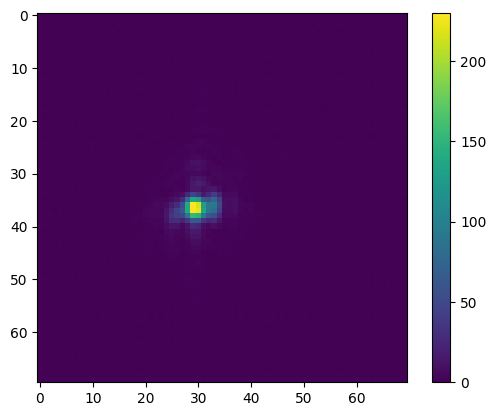

In [40]:
## Determine camera settings
PixelValueOne = c_uint(255)
PixelValueTwo = c_uint(100)
PixelsPerStripe = c_uint(16)
## Settings + Initialize camera
NumDataPoints = 256
NumRegions =1 ## If we need regional calibration, set this to 64
### numFrames determines how many times we will take a picture of a set diffraction grating. I recommend 3~5 to get a good average. 
numFrames = 3
AI_Intensities = np.zeros([NumRegions, NumDataPoints], np.float32, 'C')


# REMEMBER TO ADD IN THE WAVEFRONT CORRECTION
millisec = 1
exposure=f'{millisec}ms'

testpixelval = c_uint(255 - 20) # testmax
image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,0,c_uint(NumRegions),RGB)
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
sleep(0.03)
frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
plt.imshow(frame[480:550, 730:800])
plt.colorbar()


In [41]:
## NOTE TO SELF: WRITE SOME CODE HERE THAT WILL CORRECT FOR TOO LOW/HIGH EXPOSURE
millisec = 1
exposure=f'{millisec}ms'
ymin = 480
ymax =550
xmin = 730
xmax = 800


for region in range(0,NumRegions,1):
    # region = 3
    validregion = True
    print("Region: %d\n", region)
    exposure=f'{millisec}ms'
    # initial calibration
    ## Test max = 60, Test min = 110
    testpixelval = c_uint(255 - 60) # testmax
    image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    sleep(0.03)
    frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    testmaxval = np.max(frame[ymin:ymax, xmin:xmax])
    
    
    testpixelval = c_uint(255 - 110) # testmin
    image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    sleep(0.03)
    frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    testminval = np.max(frame[ymin:ymax, xmin:xmax])
    # if (10 > testminval or testmaxval < 230):
    #     millisec = 0.5
    # while 10 > testminval or testmaxval < 230:
    #     if millisec > 10:
    #         print("error")
    #         AI_Intensities[region, :] = 0
    #         validregion = False
    #     millisec += 0.1
    #     exposure=f'{millisec}ms'

    #     testpixelval = c_uint(255 - 60) # testmax
    #     image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    #     image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    #     slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    #     sleep(0.03)
    #     frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    #     testmaxval = np.max(frame[ymin:ymax, xmin:xmax])
        
        
    #     testpixelval = c_uint(255 - 110) # testmin
    #     image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    #     image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    #     slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    #     sleep(0.03)
    #     frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    #     testminval = np.max(frame[ymin:ymax, xmin:xmax])
        
        
    
    if validregion:
        for gray in range(0,NumDataPoints,1):
            print("Gray: %d\r", gray)
            PixelValueTwo = c_uint(255-gray)
            image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
            image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
            slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
            sleep(0.03)
            net = 0
            for frames in range(0, numFrames, 1):
                #Important: exposure_time can be set to your liking, choose one that's best for saturation
                frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
                numpix = 0 
                #this region has to be handled by you!!! Find the region where the 0th order / 1st order spot is
                #You can average over nearby pixels, take the max value, or something else. 
                #You can find where the desired spot is by passing a diffraction grating to the SLM manually and opening the Thorlabs camera in Python. Then translate camera to an array, find points on array, and put in coords. Code for this should be available above.
                net += np.max(frame[ymin:ymax, xmin:xmax])
            AI_Intensities[region, gray] = net / numFrames
            # this will give you an indicator of your pixel values. make sure there's no over/under saturation!



Region: %d
 0
 0ay: %d
 1ay: %d
 2ay: %d
 3ay: %d
 4ay: %d
 5ay: %d
 6ay: %d
 7ay: %d
 8ay: %d
 9ay: %d
 10y: %d
 11y: %d
 12y: %d
 13y: %d
 14y: %d
 15y: %d
 16y: %d
 17y: %d
 18y: %d
 19y: %d
 20y: %d
 21y: %d
 22y: %d
 23y: %d
 24y: %d
 25y: %d
 26y: %d
 27y: %d
 28y: %d
 29y: %d
 30y: %d
 31y: %d
 32y: %d
 33y: %d
 34y: %d
 35y: %d
 36y: %d
 37y: %d
 38y: %d
 39y: %d
 40y: %d
 41y: %d
 42y: %d
 43y: %d
 44y: %d
 45y: %d
 46y: %d
 47y: %d
 48y: %d
 49y: %d
 50y: %d
 51y: %d
 52y: %d
 53y: %d
 54y: %d
 55y: %d
 56y: %d
 57y: %d
 58y: %d
 59y: %d
 60y: %d
 61y: %d
 62y: %d
 63y: %d
 64y: %d
 65y: %d
 66y: %d
 67y: %d
 68y: %d
 69y: %d
 70y: %d
 71y: %d
 72y: %d
 73y: %d
 74y: %d
 75y: %d
 76y: %d
 77y: %d
 78y: %d
 79y: %d
 80y: %d
 81y: %d
 82y: %d
 83y: %d
 84y: %d
 85y: %d
 86y: %d
 87y: %d
 88y: %d
 89y: %d
 90y: %d
 91y: %d
 92y: %d
 93y: %d
 94y: %d
 95y: %d
 96y: %d
 97y: %d
 98y: %d
 99y: %d
 100: %d
 101: %d
 102: %d
 103: %d
 104: %d
 105: %d
 106: %d
 107: %d
 108: %d
 109:

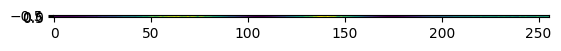

In [42]:
plt.imshow(AI_Intensities)

In [45]:
AI_Intensities = AI_Intensities[0] / np.max(AI_Intensities[0]) * 255
AI_Intensities.flatten()
numbers = np.arange(256)
csvdata = np.stack((numbers,AI_Intensities),axis=1)
np.savetxt('Raw0.csv',csvdata, delimiter = ",", fmt='%s')

In [ ]:
np.savez_compressed("globalcalibrationraw/globalcalibration.npz", array1=AI_Intensities)
for regions in range(0,64,1):
    filename = f"globalcalibrationraw/Raw{regions}.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for datapoints in range(NumDataPoints):
            writer.writerow([datapoints, AI_Intensities[regions, datapoints]])
